GenJAX is a swiss army knife for probabilistic machine learning: it's designed to support probabilistic modeling workflows via concise idioms, and to the resulting code extremely fast and parallelizable via JAX.

In this introduction, we'll focus on one such workflow: writing a latent variable model (we often say: a generative model) which describes a probability distribution over latent variables and data, and then asking questions about the conditional distribution over the latent variables given data.

In the following, we'll often shorten GenJAX to Gen -- because [GenJAX implements Gen](https://www.gen.dev/).

In [1]:
import genjax
from genjax import pretty
from genjax import gen, normal
from jax import random as jrand
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")
%config InlineBackend.figure_format = 'svg'

pretty()  # pretty print the types

## Generative functions 

In [2]:
@gen
def model():
    x = normal(0.0, 1.0) @ "x"
    y = normal(x, 1.0) @ "y"


model

StaticGenerativeFunction(...)

In Gen, probabilistic models are represented by a computational object called _a generative function_. Once we create one of these objects, we can use one of several interfaces to gain access to probabilistic effects.

Here's one interface: `simulate` -- this samples from the probability distribution which the program represents, and stores the result, along with other data about the invocation of the function, in a data structure called a `Trace`.

In [3]:
key = jrand.PRNGKey(0)
tr = model.simulate(key, ())
tr

StaticTrace(...)

We can dig around in this object uses its interfaces:

In [4]:
chm = tr.get_sample()
chm

ChoiceMap(...)

A `ChoiceMap` is a representation of _the sample_ from the probability distribution which the generative function represents. We can ask _what values were sampled_ at the addresses (the `"x"` and `"y"` syntax in our model):

In [5]:
(chm["x"], chm["y"])

(<jax.Array(-1.2515389, dtype=float32)>,
 <jax.Array(-1.8381894, dtype=float32)>)

Neat -- all of our interfaces are JAX compatible, so we could sample 1000 times just by using `jax.vmap`:

In [6]:
sub_keys = jrand.split(jrand.PRNGKey(0), 1000)
tr = jit(vmap(model.simulate, in_axes=(0, None)))(sub_keys, ())
tr

StaticTrace(...)

Let's plot our samples to get a sense of the distribution we wrote down.

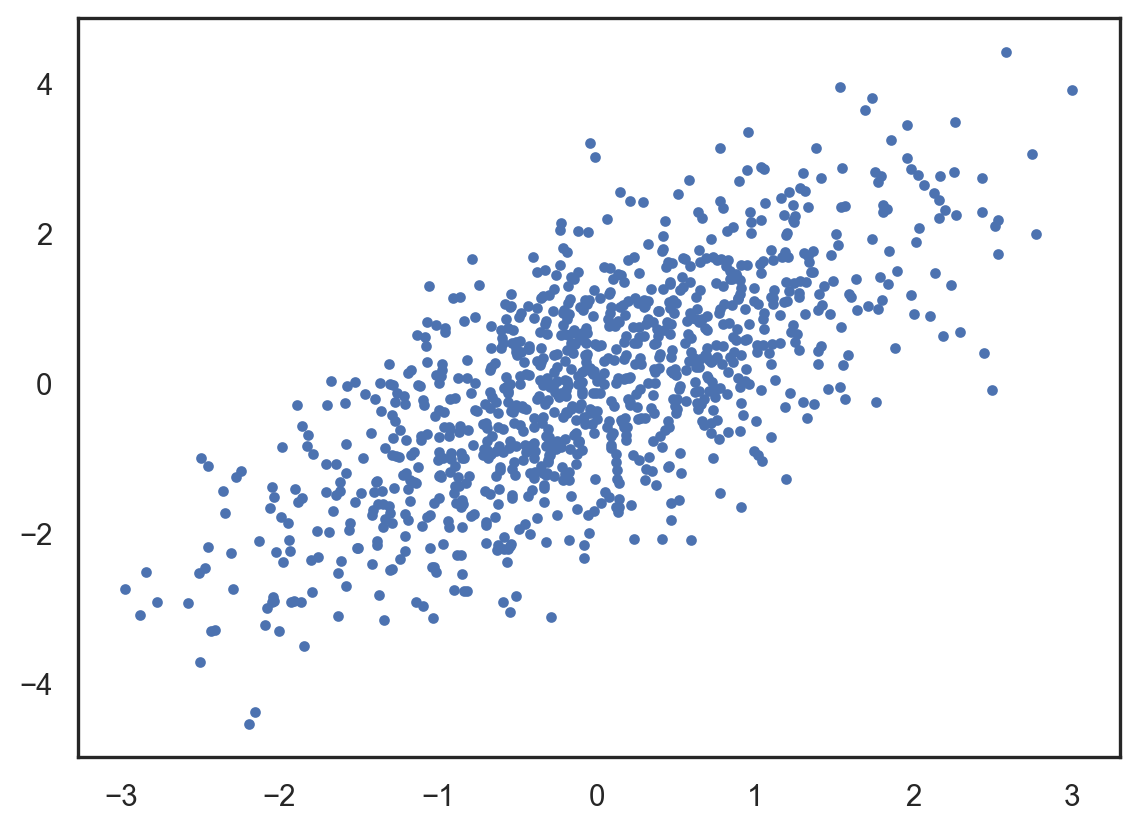

In [7]:
chm = tr.get_sample()
plt.scatter(chm["x"], chm["y"], marker=".")

Traces also keep track of other data, like _the score_ of the execution (which is a value which estimates the joint probability of the random choices under the distribution):

In [8]:
tr.get_score()

<jax.Array float32(1000,) ≈-2.9 ±0.97 [≥-8.3, ≤-1.8] nonzero:1_000
  <Arrayviz rendering>
>

## Composition of generative functions

Generative functions are probabilistic building blocks. You can combine them into larger probability distributions:

In [9]:
# A regression distribution.
@gen
def regression(x, coefficients, sigma):
    basis_value = jnp.array([1.0, x, x**2])
    polynomial_value = jnp.sum(basis_value * coefficients)
    y = genjax.normal(polynomial_value, sigma) @ "value"
    return y


# Regression, with an outlier random variable.
@gen
def regression_with_outlier(x, coefficients):
    is_outlier = genjax.flip(0.1) @ "outlier"
    sigma = jnp.select(is_outlier, 0.3, 30.0)
    is_outlier = jnp.array(is_outlier, dtype=int)
    return regression(x, coefficients, sigma) @ "y"


# The full model, sample coefficients for a curve, and then use
# them in independent draws from the regression submodel.
@gen
def full_model(xs):
    coefficients = (
        genjax.mv_normal(
            jnp.zeros(3, dtype=float),
            2.0 * jnp.identity(3),
        )
        @ "alpha",
    )
    ys = regression_with_outlier(in_axes=(0, None))(xs, coefficients) @ "ys"
    return ys

## Inference in generative functions

Now that we've seen a few ways to build up larger generative functions from smaller ones, we should tackle...